## Pretrained GAN

In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

import warnings
warnings.filterwarnings('ignore')

In [0]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

### Crappified data

Prepare the input data by crappifying images. Customize the data as per requirement. We are resizing the images and randomly taking a number and drawing the number on the image and saving the image with that number quality.

In [0]:
from PIL import Image, ImageDraw, ImageFont

In [0]:
def crappify(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    w,h = img.size
    q = random.randint(10,70)
    ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
    img.save(dest, quality=q)

In [0]:
il = ImageImageList.from_folder(path_hr)
parallel(crappify, il.items)

In [0]:
bs,size=32, 128
# bs,size = 24,160
# bs,size = 8,256
arch = models.resnet34

### Pre-train generator

In [0]:
def get_data(bs,size):
    data = (ImageImageList.from_folder(path_lr)
           .random_split_by_pct(0.1, seed=42)
           .label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
data_gen = get_data(bs,size)

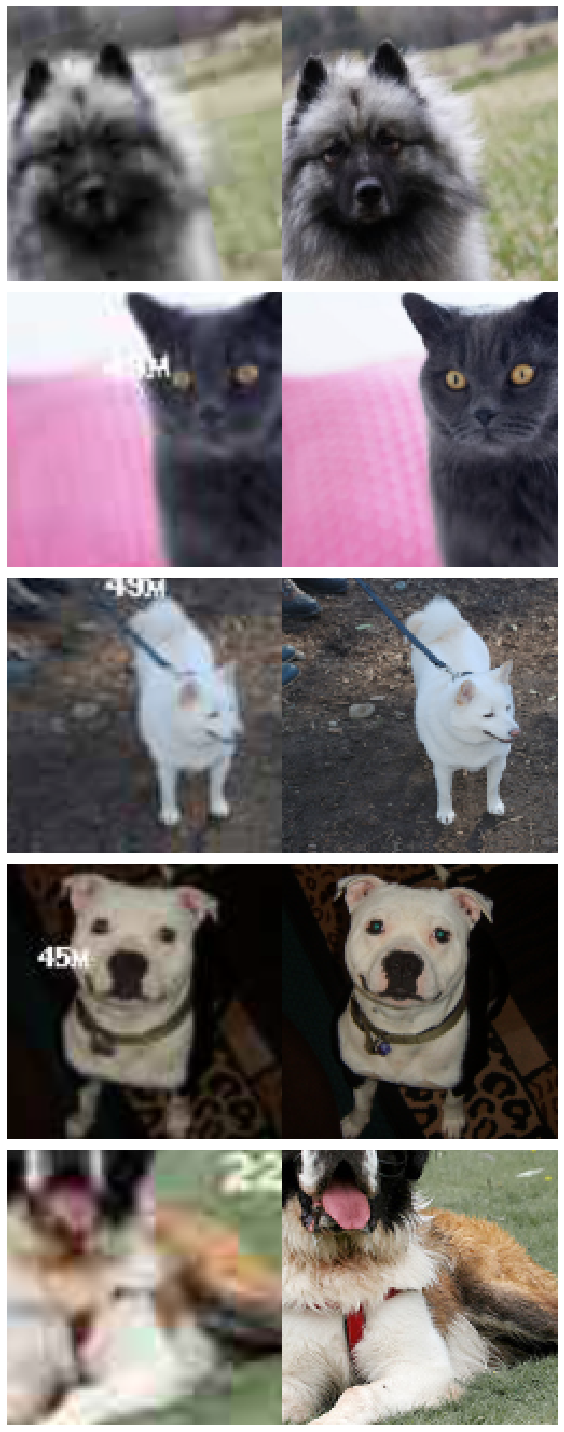

In [9]:
data_gen.show_batch()

In [0]:
wd = 1e-3
y_range = (-3.,3.)
loss_gen = MSELossFlat()

In [0]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [0]:
learn_gen = create_gen_learner()

In [13]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss,time
0,0.066032,0.054013,03:23
1,0.053015,0.047262,02:59


In [0]:
learn_gen.unfreeze()

In [15]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

epoch,train_loss,valid_loss,time
0,0.051992,0.046594,03:10
1,0.049503,0.044586,03:09
2,0.048115,0.043468,03:09


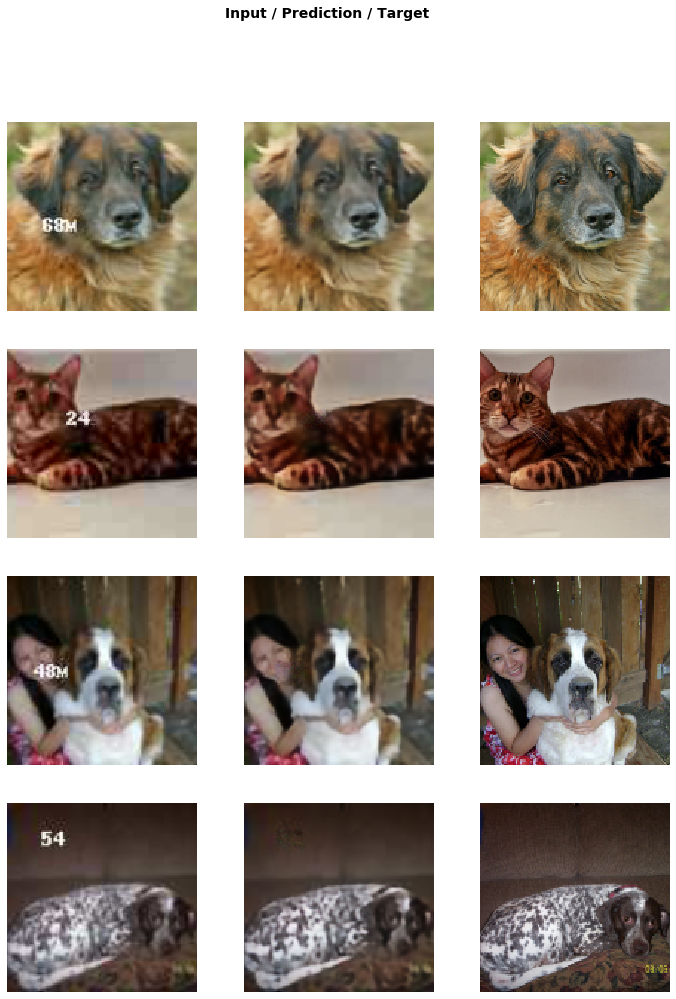

In [16]:
learn_gen.show_results(rows=4)

In [0]:
learn_gen.save('gen-pre2')

### Save generated images

In [0]:
learn_gen.load('gen-pre2');

In [0]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [0]:
path_gen.mkdir(exist_ok=True)

In [0]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [0]:
save_preds(data_gen.fix_dl)

### Train

In [24]:
learn_gen=None
gc.collect()

13

In [0]:
def get_data(bs,size):
    data = (ImageImageList.from_folder(path_gen)
           .random_split_by_pct(0.1, seed=42)
           .label_from_func(lambda x: path_hr/x.relative_to(path_gen))
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
data = get_data(bs,size)

In [0]:
# Feature loss with MSE loss as base loss 
base_loss = MSELossFlat() # 

def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

from torchvision.models import vgg16_bn
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

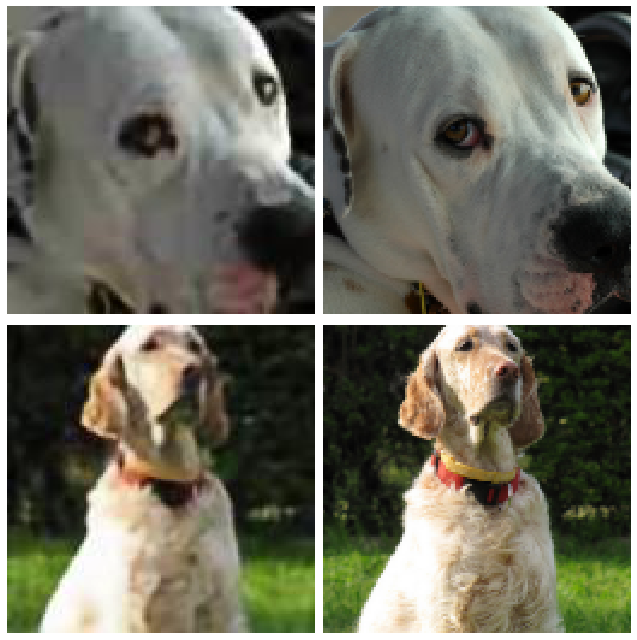

In [31]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

In [0]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight)
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


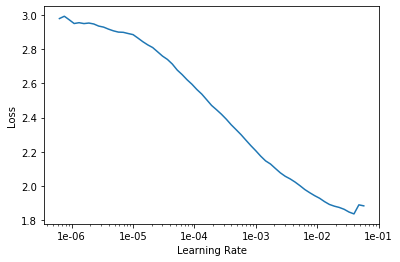

In [32]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-3

In [0]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(5, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.161813,0.593306,0.147423,0.070080,0.084840,0.289730,0.000011,0.000008,0.001214,03:49
1,1.165069,0.666108,0.200270,0.072656,0.087555,0.304335,0.000011,0.000008,0.001273,03:40
2,1.141686,0.569425,0.155667,0.065516,0.079428,0.267680,0.000011,0.000007,0.001115,03:38
3,1.134002,0.661448,0.221510,0.069285,0.083302,0.286135,0.000011,0.000008,0.001198,03:37
4,1.108661,0.595741,0.181184,0.066232,0.079301,0.267876,0.000011,0.000007,0.001130,03:36


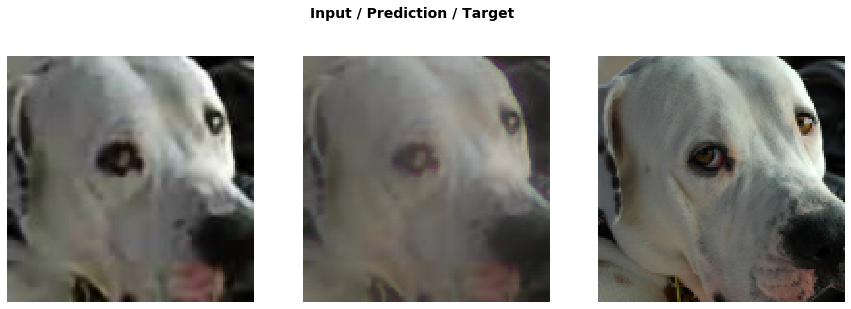

In [35]:
do_fit('1a', slice(lr*10))

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.104704,0.604774,0.189893,0.066348,0.079310,0.268074,0.000011,0.000007,0.001130,03:46
1,1.095734,0.595510,0.185959,0.066120,0.078668,0.263634,0.000011,0.000007,0.001111,03:46
2,1.092511,0.588718,0.182565,0.065643,0.078089,0.261303,0.000011,0.000007,0.001100,03:45
3,1.108596,0.600263,0.191607,0.066121,0.078627,0.262782,0.000011,0.000007,0.001107,03:46
4,1.101047,0.595404,0.190883,0.065850,0.078039,0.259519,0.000011,0.000007,0.001094,03:46


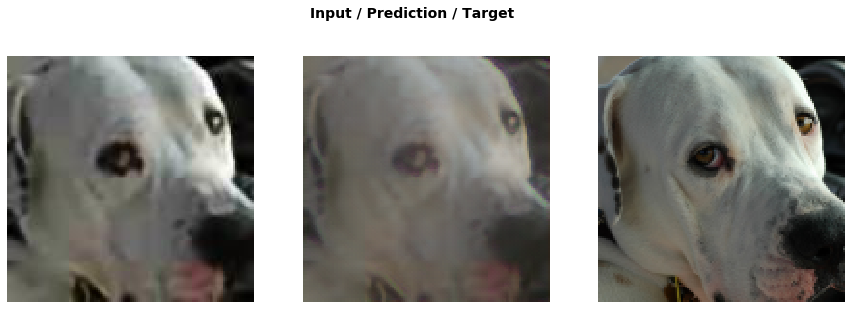

In [36]:
learn.unfreeze()
do_fit('1b', slice(1e-5,lr))

In [0]:
data = get_data(12,size*2)

In [38]:
learn.data = data
learn.freeze()
gc.collect()

16401

In [0]:
learn.load('1b');

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,0.895760,0.601562,0.274679,0.076974,0.071035,0.178722,0.000015,0.000002,0.000135,15:43
1,0.910905,0.606181,0.278457,0.076497,0.070561,0.180512,0.000015,0.000002,0.000137,15:12
2,0.906452,0.607622,0.281976,0.075321,0.069918,0.180253,0.000015,0.000002,0.000137,15:13
3,0.874891,0.558732,0.241706,0.072747,0.068407,0.175723,0.000012,0.000002,0.000134,15:14
4,0.913684,0.599541,0.275475,0.073141,0.069083,0.181688,0.000014,0.000002,0.000138,15:17


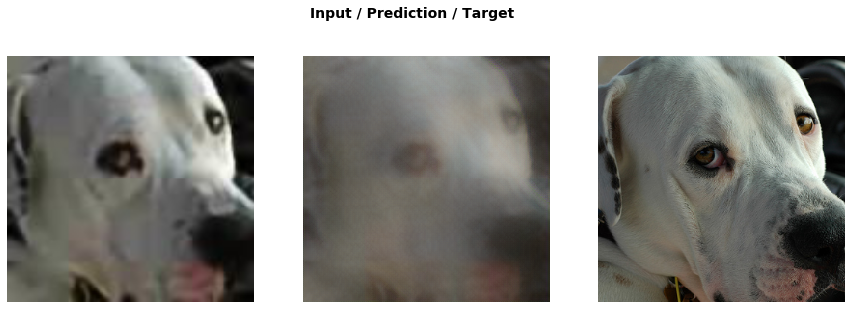

In [40]:
do_fit('2a')

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,0.860609,0.594562,0.272386,0.072755,0.068777,0.180490,0.000013,0.000002,0.000138,15:53
1,0.887289,0.599880,0.277425,0.072845,0.068836,0.180622,0.000013,0.000002,0.000138,15:49
2,0.864513,0.597574,0.275146,0.072706,0.068779,0.180790,0.000013,0.000002,0.000138,15:45
3,0.897601,0.614589,0.290120,0.073270,0.069153,0.181892,0.000013,0.000002,0.000138,15:45
4,0.886374,0.598859,0.277791,0.072301,0.068509,0.180105,0.000013,0.000002,0.000137,15:45


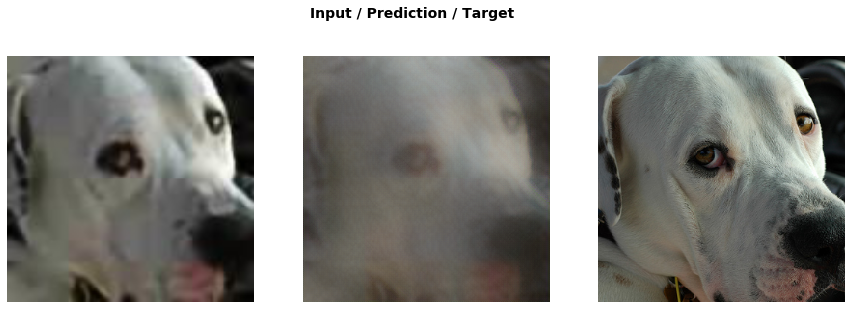

In [41]:
learn.unfreeze()
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

### Test

In [0]:
learn = None
gc.collect();

In [0]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)